# P-Tuning & P-Tuning v2

## Reference:
- P-tuning的论文大白话阅读笔记和代码实现.https://zhuanlan.zhihu.com/p/522253942
- P-Tuning v2 论文笔记.https://zhuanlan.zhihu.com/p/496340353
- Latex 字母上方箭头.https://blog.csdn.net/weixin_43846270/article/details/109113181
- 固定LM参数微调Prompt: P-Tuning方法. https://zhuanlan.zhihu.com/p/622046422

## P-Tuning


### 1. Introduction:

#### 1) Pre-train Language Model Categories:
- undirectional: GPT NLG
- bidirectional: Bert NLU
- hybrid: XLNet, UniLM paradiams combining

#### 2) Problems:
- GPTs do not perform well in NLU tasks
- GPTs require large validation sets. Hence, if using prompt engineering, overfitting test set.
- Discrete prompt will get sub-optimal, owing to inherently continuous of neural networks.

#### 3) Main Ideas of P-tuning:
- leverage few *continuous free parameters* to serve prompts fed as inputs to pre-trained language model.
- non-invasive modification to input by replacing inputs embeddings with **pretrained LM's output embedding**.
- optimize continuous prompt using <u>gradient descent</u>.

#### 4) Benchmark:
- LAMA knowledge probing: model parameters are fixed, no fine-tuned.
  - knowledge probing:
    - also called fact retrieval
    - test how much real world knowledge has LM gained from pre-training.
- SuperGLUE

#### 5) Contributions of P-Tuning:
1. Make GPTs perform as well as Berts in NLU tasks with P-Tuning.
2. Improve GPTs and Berts in Few-Shot and fully-supervised settings.
  - Recap: in few-shot prompting, LLM is given a few examples of the desired task in addition to the description.

### 2. Architecture

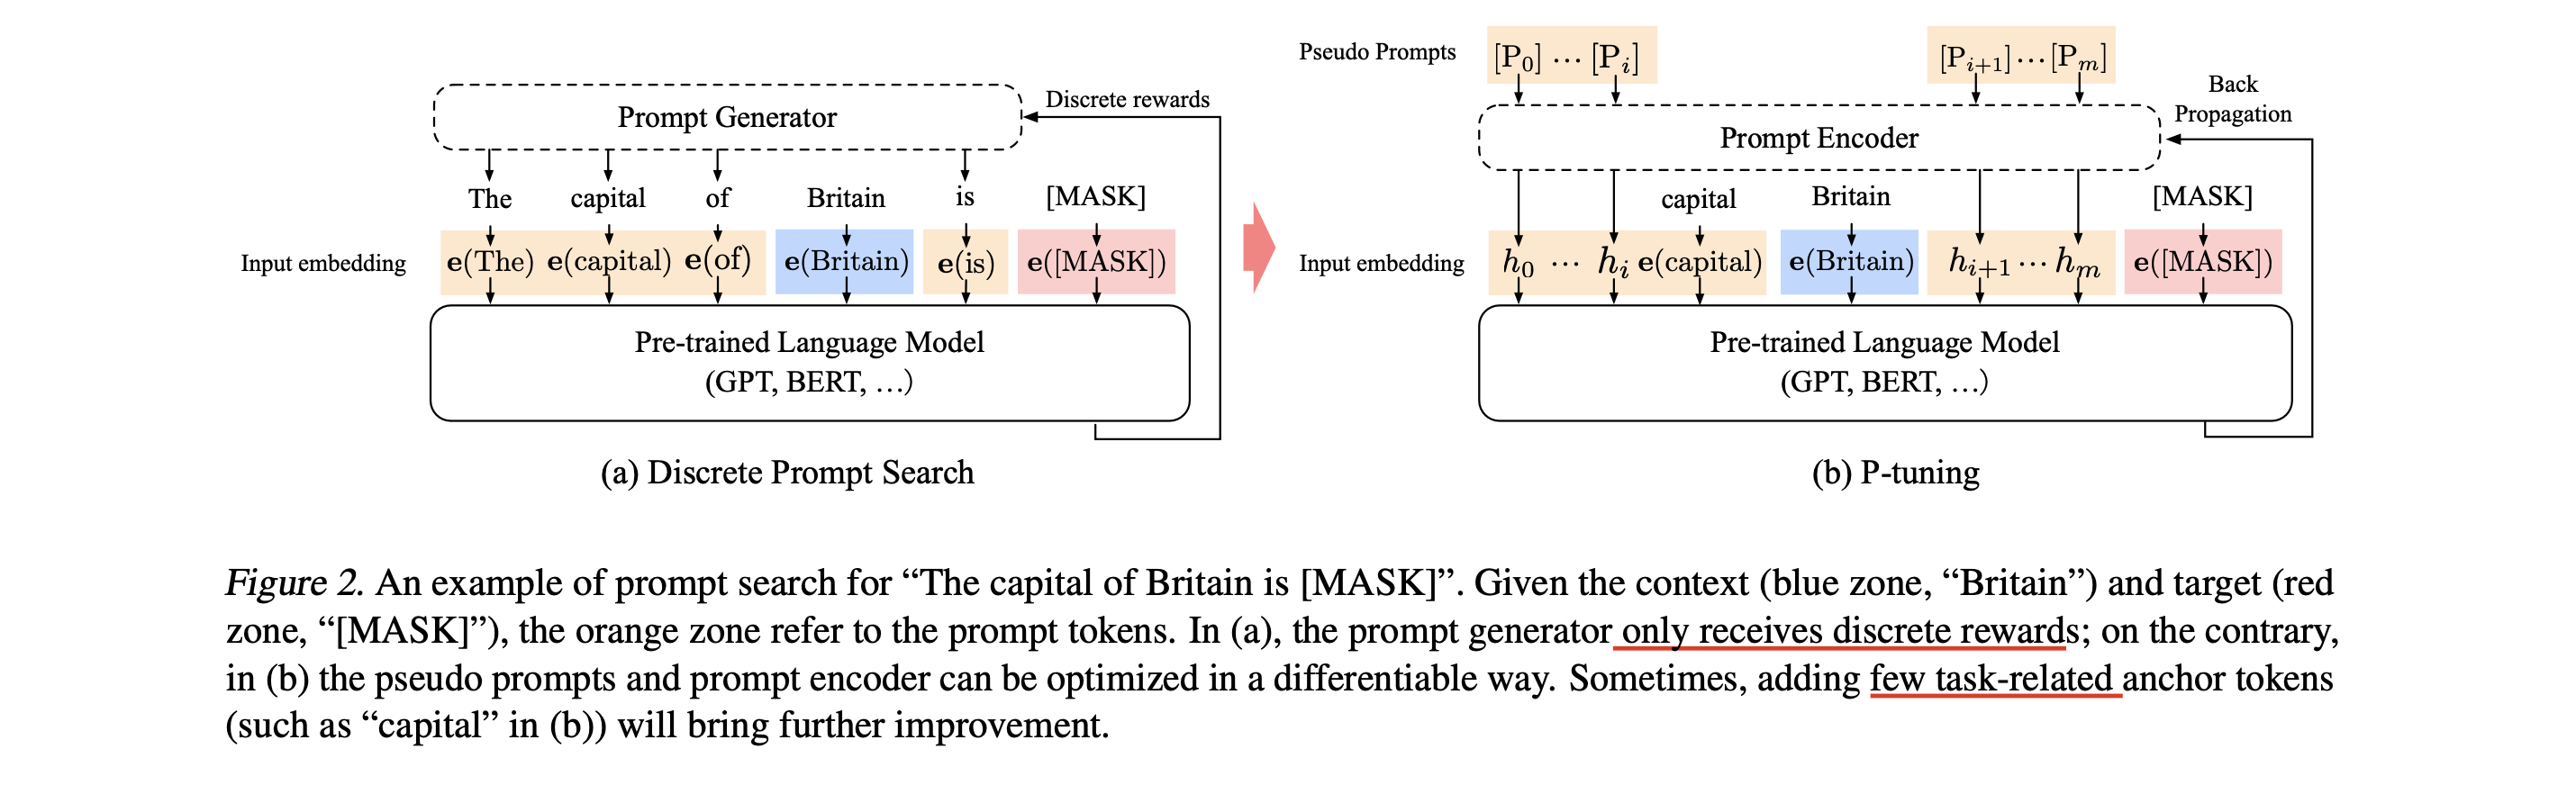

#### Notions
- Input Tokens$x_{1:n}=\lbrace x_0,x_1,...,x_n \rbrace$→pre-trained embedding layer $e \in 𝛭$(pre-trained LM)→input embeddings $\lbrace e(x_0),e(x_1),...,e(x_n) \rbrace$
- $x$: context input
- $y$: target, it can be `[MASK]`, `[CLS]`...for different tasks.
- $p$: prompt
- $𝓥$: vocabulary of lanugage model
- $[P_i]$: $i^{th}$ prompt token in template $T$
- Given templete: $T=\lbrace [P_{0:i}],x,[P_{i+1:m}],y\rbrace$
  - Discrete prompt: $\lbrace e([P_{0:i}]),e(x),e([P_{i+1:m}]), e(y) \rbrace$
  - P-tuning method: $\lbrace h_0,...,h_i,e(x),h_{i+1},...,h_m, e(y) \rbrace$
    - $h_i(0≤i≤m)$: trainable embedding tensors, helping us to <u>automatically find a better continuous prompt</u> beyond original vocabulary $𝓥$.
    - it takes $[P_i]$ as *pseudo tokens*.
- optimize continuous prompt differentially:
  - $\hat{h}_{0:m}=arg \space min_h L(𝛭(x,y))$
    - $L$: downstream loss function

#### Two Optimization Challenges:
1. Discret:
- Word embedding $e$ is already <u>highly discrete</u> after pre-training.
- If $h$ is initialized in *normal distribution* and optimized with SGD→SGD only can change parameters in a small neighborhood, fall into **local minma**.
2. Association: we need structures to associate prompt embeddings $h_i$ with each other, owing to they are *not independent*.

#### Solutions: Architecture Design
- `prompt encoder layer`
  - Structure: LSTM + ReLU activation function + 2 layers MLP
  - $h_i=MLP([\mathop{h_i}\limits ^{\rightarrow}:\mathop{h_i}\limits ^{\leftarrow}])=MLP([LSTM(h_{0:i}):LSTM(h_{i:m})])$

### Knowledge Probing Training

#### Dataset
- Because the vocabulary of GPT and Bert are different, we choose the intersection of two kinds LM vocabulary, using **LAMA-29k** with 29000 testing triples$(a,b,c)$.
- Generally, follow setting from AutoPrompt.

#### Settings
- learning rate=1e-5
- optimizer: Adam
- Bidirectional masked language model
  - replace `[x]` with subject entity
  - replace `[y]` with `[MASK]` token
  - Format: $(3, \space subject,3, \space object,3)$
    - 3: number of prompt tokens
- Unidirectional masked language model
  - use network output before the target position
  - Format: $(3, \space subject,3, \space object)$
- In knowledge probing task, we use no anchor tokens.

#### Evaluation Results
- LM can capture more knowledge than expected with a better prompting and without fine-tuning.
  - Original LAMA-34k 43.3%→50.6%
  - LAMA-29k 45.2%→64.2%
  - outperform with discrete prompting(eg: Autoprompt) on same-size model.
- Four Strategies:
  - MP: orginial handcraft from LAMA
  - P-tuning: use continuous prompts without changing pre-trained models' parameters
  - FT:
    - present the subject
    - fine-tune all parameters of the model to predict the object

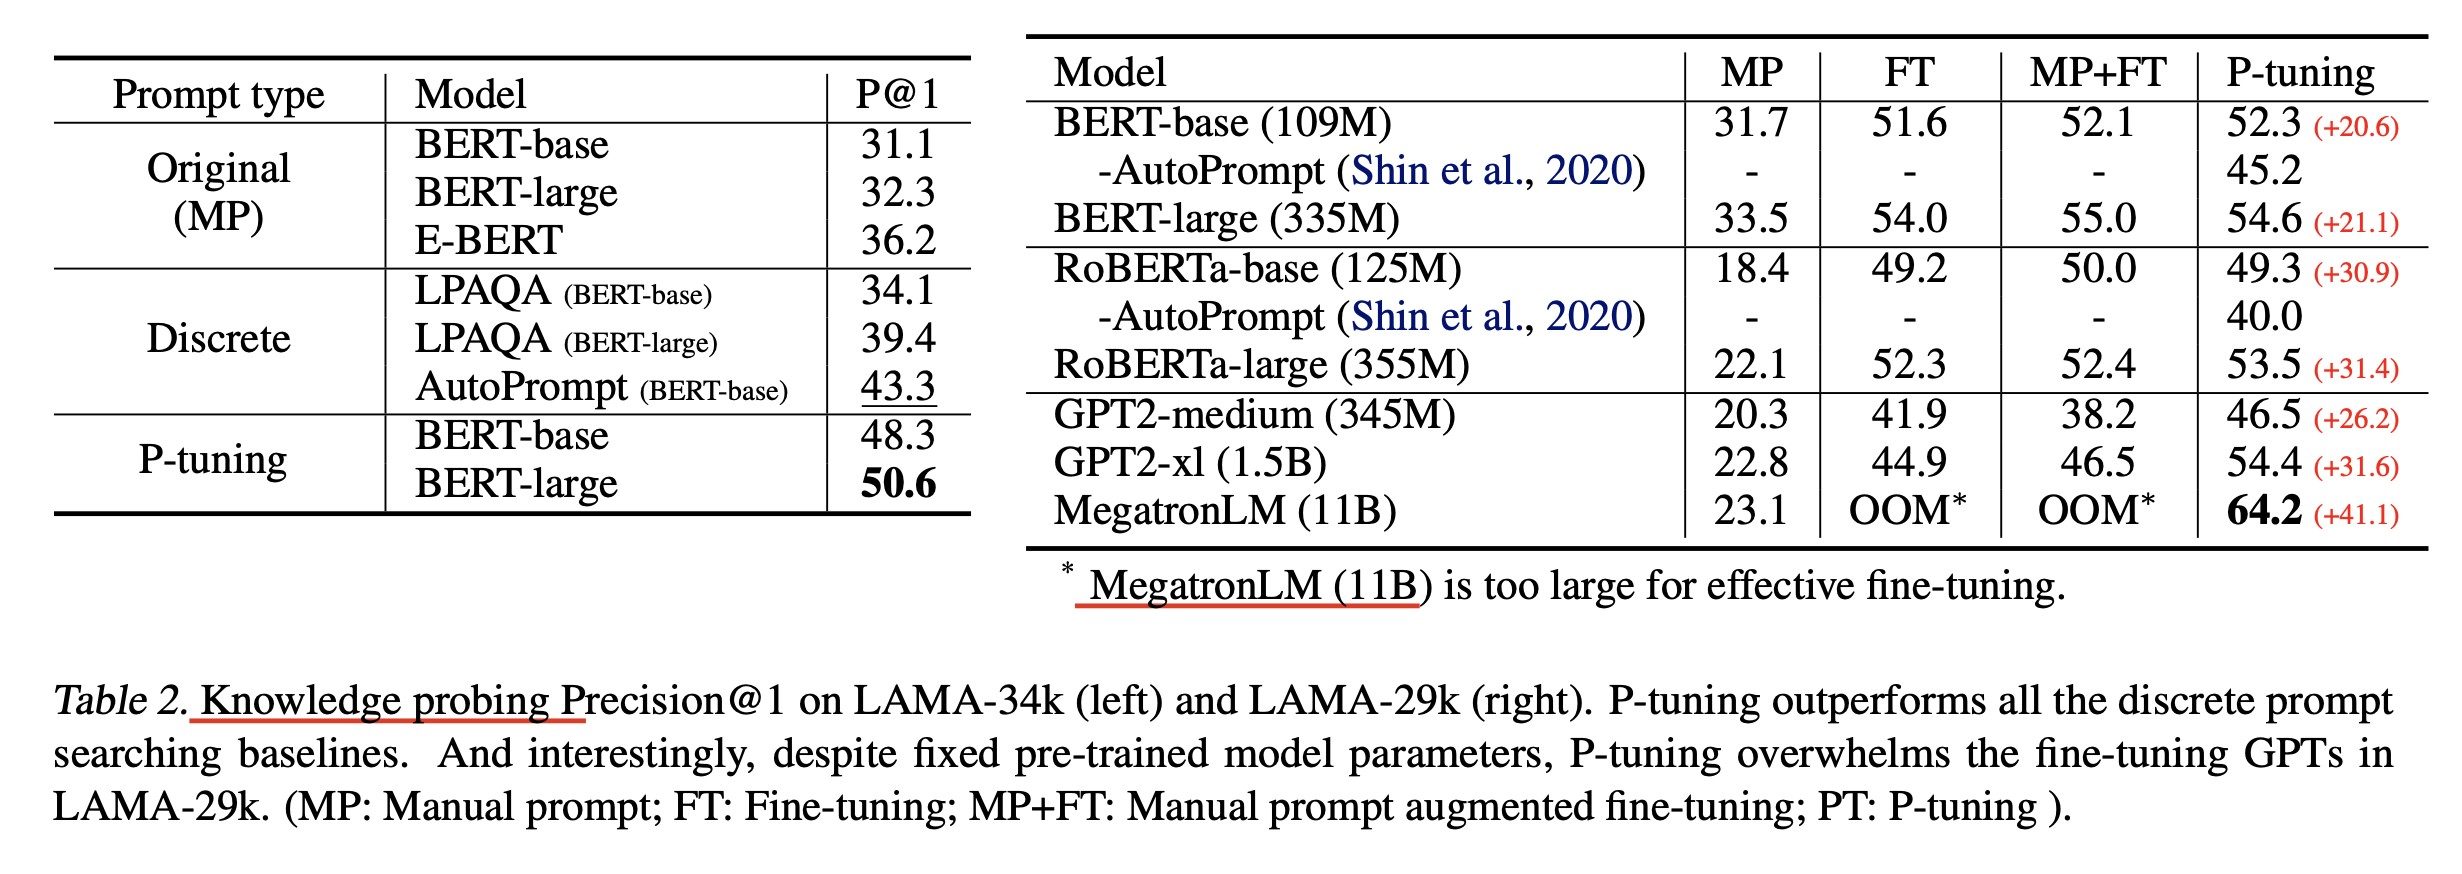

### SuperGLUE
- Components: 8 NLU tasks in original version, here author only focus on 7 without ReCoRD.
  - question answering: BoolQ, MultiRC
  - textual entailment: CB, RTE
  - Co-reference resolution: WiC 识别文本中指代相同实体的不同表达方式
  - causal reasoning: COPA
  - word sense disambiguation: WSC 词义消歧
- Form: black filling tasks.
- Experimental setting:
  - **Fully Supervised**: use <u>entire training and development datasets</u> for model selection and hyperparameter tuning.
    - Optimizer: AdamW
    - learning rate: linearly decayed
    - Hyperparameter tuning: find with grid search
        - learning rate: 1e-5,2e-5,3e-5
        - batch size: 16, 32
        - num_epochs:
          - for small dataset: 20
          - for large dataset: 10
    - early stop: prevent overfitting
  - **Few-Shot**: with FewGLUE $D_{train32}$ and $D_{dev32}$
    - $D_{dev32}$: select samples from unused training data, size < few-shot train set
    - Hyperparameter setting: the same as fully supervised, except *fine-tune step=3500* for prompt embeddings.
  - Evaluation Metrics: **F1 score and Accuracy** for FT, MP zero-shot, MP fine-tuning, P-tuning methods.
- Model Selection:
  - Bert-Base & GPT-2 base
  - Bert-Large & GPT-medium


### Comparison Between Prefix Tuning and P-Tuning

#### 1. Differences
1. Prefix tuning focuses on *NLG and GPTs*, while P-Tuning focus on *NLU and all types* of language models.
2. Prefix tuning only allows to add prompt tokens at *beginning* of input sequence, while P-tuning allows to insert prompt tokens *anywhere*.
3. Prefix tuning invasively concatenates continuous tokens in *each transformer layer*, while P-tuning non-invasively add continuous tokens only *in the input*.
4. Additionally, P-tuning introduces how to use *anchor prompts*.

#### 2. Similarities
- Both of them state that *continuous prompts* is useful and superior to discrete prompt searching.

### Drawbacks
- Easy to get overfitting
- Poor interpretability
- Slower convergency
- Unstable: some results cannot repulicate for SuperGLUE.

## P-Tuning v2

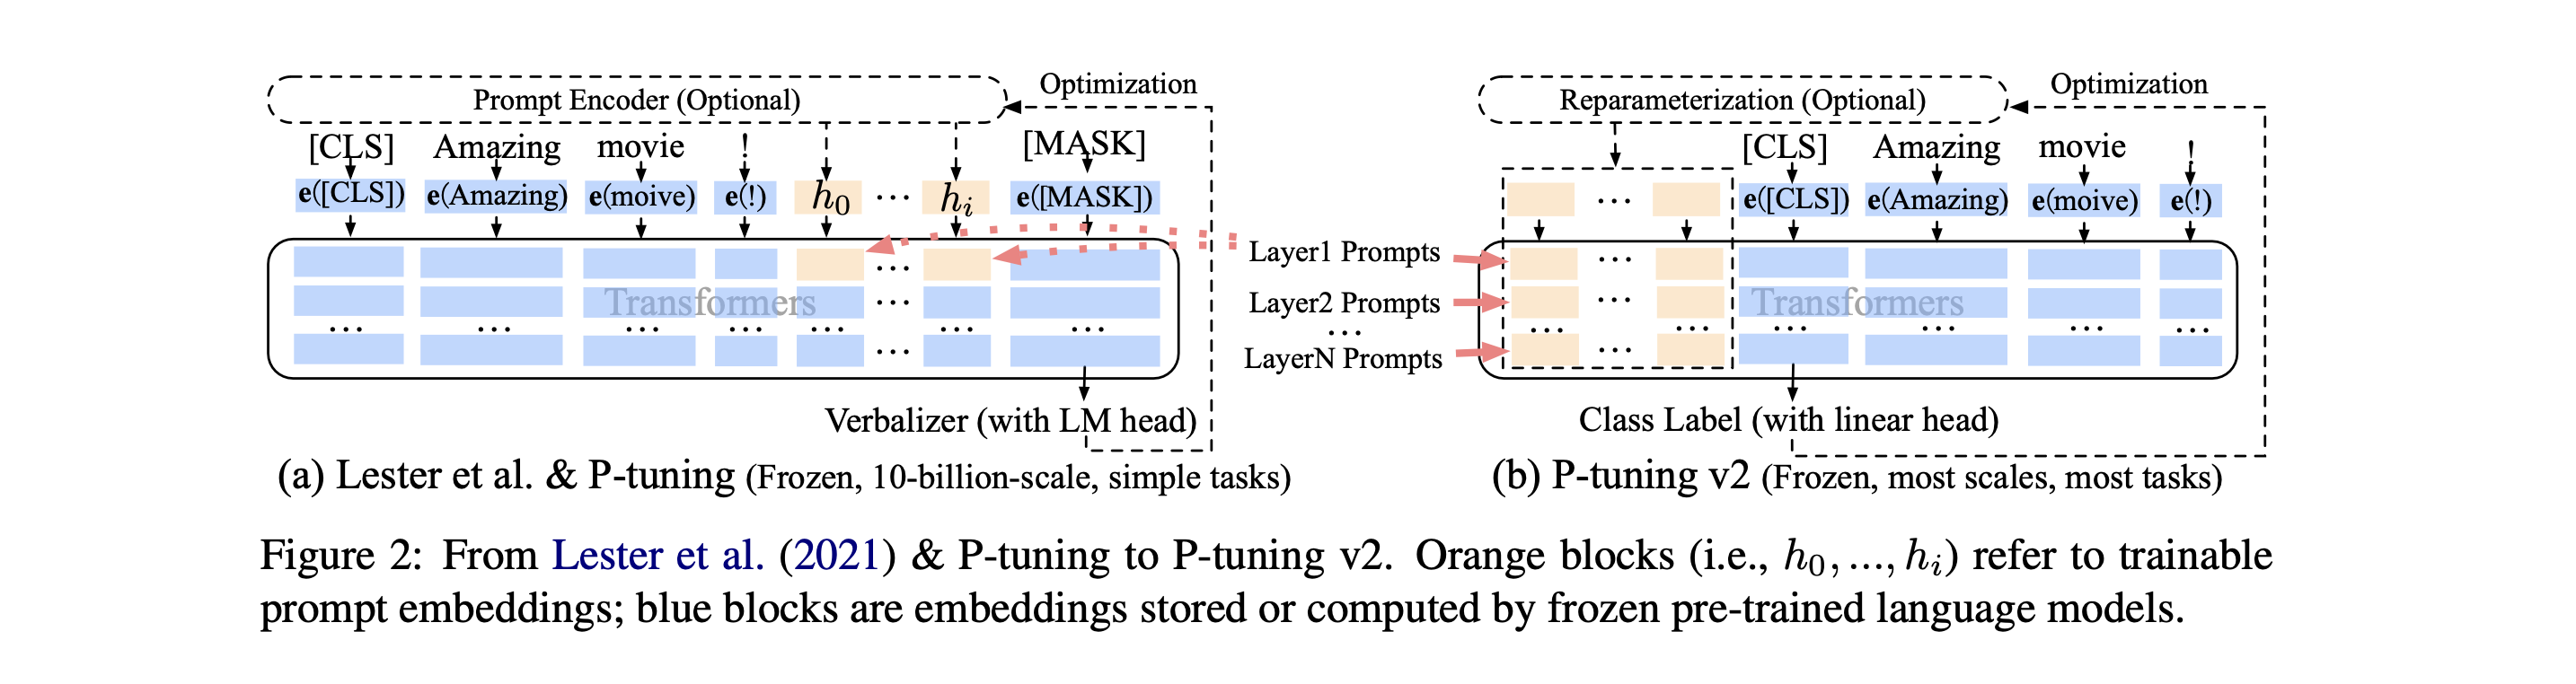